In [1]:
import os
import pickle
import sys

import copy
import random
import joblib
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from matplotlib import pyplot as plt
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

sys.path.append("..")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from src.model_utils import reshape_data
from src.dataprocessing import generate_subsets, generate_blocks

## Paths to data

In [2]:
# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

pathTarget = os.path.join(os.path.join(path_to_npys_data, "target_croplands.npy"))
pathFeatures = os.path.join(path_to_npys_data, "features_initial_data.npy")
pathMorf = os.path.join(path_to_npys_data, "features_morf_data.npy")
pathTarget_tif = os.path.join("..", "data", "target", "target_croplands.tif")

##  Data

In [3]:
# Features
climate_features = pd.DataFrame.from_dict(
    np.load(pathFeatures, allow_pickle=True), orient="columns"
)
morf_features = pd.DataFrame.from_dict(
    np.load(pathMorf, allow_pickle=True), orient="columns"
)

climate_keys = list(climate_features.keys())
morf_keys = list(morf_features.keys())

with open(os.path.join(path_to_npys_data, "climate_keys.pkl"), "wb") as file:
    pickle.dump(climate_keys, file)

with open(os.path.join(path_to_npys_data, "morf_keys.pkl"), "wb") as file:
    pickle.dump(morf_keys, file)

In [4]:
# Target Variable
y = pd.DataFrame.from_dict(np.load(pathTarget, allow_pickle=True), orient="columns")
y = y["Target"].astype(int)
# Set classes 4,5 to 0
y = pd.DataFrame({"target": np.where(y > 3, 0, y)})

In [5]:

pth_raw_tgt = os.path.join("..", "data", "target", 'target_croplands.tif')
geotiff_da = rxr.open_rasterio(pth_raw_tgt)

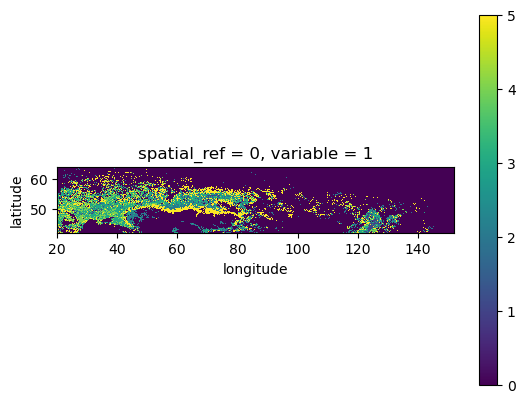

In [6]:
geotiff_ds = geotiff_da.to_dataset('band')
geotiff_ds = geotiff_ds.rename_dims({"x": 'longitude', "y": 'latitude'})
geotiff_ds = geotiff_ds.rename({"x": 'longitude', "y": 'latitude'})
geotiff_ds.to_array().plot()
plt.gca().set_aspect('equal')

In [7]:
y_df = geotiff_ds.to_dataframe()
y_df = y_df.drop(columns=['spatial_ref'])

In [8]:
y_df_tmp = y_df.index.to_frame().reset_index(drop=True)
y_df_tmp['Target'] = y_df.values.flatten()
y_tgt = y_df_tmp

## Data Preparation 


### Train/val/test split using pixels blocks

In [11]:
# # combine climate morf and target and then filter to make holdout 
# climate_features.drop(columns=['latitude', 'longitude'], inplace=True)
# data = pd.concat([climate_features, morf_features, y], axis=1)

# main_data = data[data['longitude'] <= 100]
# hold_out = data[(115 <= data['longitude']) & (data['longitude'] <= 135) &
#                      (42 <= data['latitude']) & (data['latitude'] <= 55)]

# X_keys = list(data.keys()[:-1])

# with open(os.path.join(path_to_npys_data, "X_keys.pkl"), 'wb') as file:
#     pickle.dump(X_keys, file)

# del data

KeyError: "['latitude', 'longitude'] not found in axis"

In [9]:
# print([v for v in climate_features.columns])

var_name_ = 'monthly_avg_temp_M11'
test_feature = climate_features[[var_name_, 'latitude', 'longitude']]
test_feature.sort_values(['latitude', 'longitude'], ascending=[True, True], inplace=True)
reshaped = test_feature[var_name_].values.reshape(len(test_feature.latitude.unique()), len(test_feature.longitude.unique()))

In [10]:
np.allclose(reshaped[0, :], test_feature[test_feature['latitude'] == test_feature['latitude'].unique().min()][var_name_].values)

True

In [11]:
data_xr = xr.DataArray(reshaped, 
    coords={'latitude': np.sort(test_feature.latitude.unique()),'longitude': np.sort(test_feature.longitude.unique())}, 
    dims=["latitude", "longitude"])

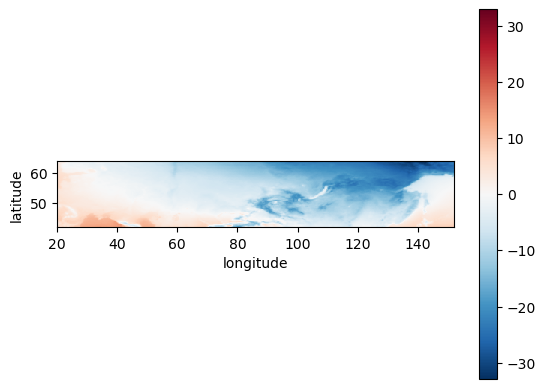

In [12]:
data_xr.plot()
plt.gca().set_aspect('equal')

['slope_47', 'aspect_47', 'shaded_relief_east_47', 'profile_convexity_47', 'plan_convexity_47', 'long_curvature_47', 'cross_convexity_47', 'min_curvature_47', 'max_curvature_47', 'shaded_relief_south_47', 'slope_11', 'aspect_11', 'shaded_relief_east_11', 'profile_convexity_11', 'plan_convexity_11', 'long_curvature_11', 'cross_convexity_11', 'min_curvature_11', 'max_curvature_11', 'shaded_relief_south_11', 'slope_3', 'aspect_3', 'shaded_relief_east_3', 'profile_convexity_3', 'plan_convexity_3', 'long_curvature_3', 'cross_convexity_3', 'min_curvature_3', 'max_curvature_3', 'shaded_relief_south_3', 'altitude', 'slope_33', 'aspect_33', 'shaded_relief_east_33', 'profile_convexity_33', 'plan_convexity_33', 'long_curvature_33', 'cross_convexity_33', 'min_curvature_33', 'max_curvature_33', 'shaded_relief_south_33', 'latitude', 'longitude']


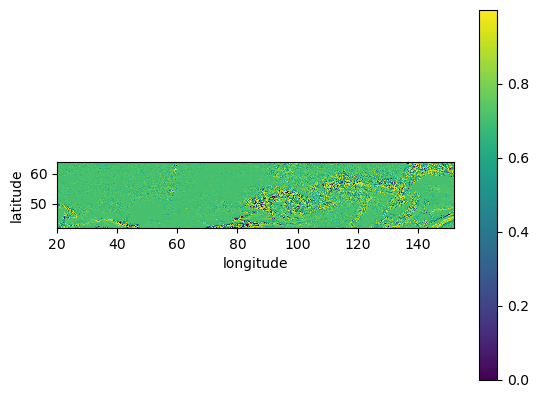

In [13]:
print([v for v in morf_features.columns])
var_name_ = 'shaded_relief_south_3'
test_feature = morf_features[[var_name_, 'latitude', 'longitude']]
test_feature.sort_values(['latitude', 'longitude'], ascending=[True, True], inplace=True)
reshaped = test_feature[var_name_].values.reshape(len(test_feature.latitude.unique()), len(test_feature.longitude.unique()))
assert np.allclose(reshaped[0, :], test_feature[test_feature['latitude'] == test_feature['latitude'].unique().min()][var_name_].values)
data_xr = xr.DataArray(reshaped, 
    coords={'latitude': np.sort(test_feature.latitude.unique()),'longitude': np.sort(test_feature.longitude.unique())}, 
    dims=["latitude", "longitude"])
data_xr.plot()
plt.gca().set_aspect('equal')

In [14]:
(morf_features[['latitude', 'longitude']] == climate_features[['latitude', 'longitude']]).all()

latitude     True
longitude    True
dtype: bool

In [23]:
((morf_features[['latitude', 'longitude']] - y_tgt[['latitude', 'longitude']]).value_counts() / len(morf_features))

latitude  longitude
0.004492  -0.004492    0.386798
          -0.004492    0.348894
          -0.004492    0.124872
          -0.004492    0.039469
          -0.004492    0.036135
          -0.004492    0.030419
          -0.004492    0.028037
          -0.004492    0.005376
dtype: float64

In [16]:
print("Top coordinate difference")
print((morf_features[['latitude', 'longitude']] - y_tgt[['latitude', 'longitude']]).abs().max(axis=0))
print("Grid resolution")
print(morf_features[['latitude']].drop_duplicates().sort_values(by='latitude').diff().abs().min())
print(morf_features[['longitude']].drop_duplicates().sort_values(by='longitude').diff().abs().min())

Top coordinate difference
latitude     0.004492
longitude    0.004492
dtype: float64
Grid resolution
latitude    0.008983
dtype: float64
longitude    0.008983
dtype: float64


In [90]:
climate_features

,air_temp_cross_0C_days_M1,air_temp_cross_0C_days_M2,air_temp_cross_0C_days_M3,air_temp_cross_0C_days_M4,air_temp_cross_0C_days_M5,air_temp_cross_0C_days_M6,air_temp_cross_0C_days_M7,air_temp_cross_0C_days_M8,air_temp_cross_0C_days_M9,air_temp_cross_0C_days_M10,...,precip_ext_days_M3,precip_ext_days_M4,precip_ext_days_M5,precip_ext_days_M6,precip_ext_days_M7,precip_ext_days_M8,precip_ext_days_M9,precip_ext_days_M10,precip_ext_days_M11,precip_ext_days_M12
0,8.1,7.6,12.6,19.299999,3.8,0.0,0.0,0.0,0.5,11.0,...,0.6,1.0,0.8,1.3,1.3,1.3,1.3,0.9,0.7,0.6
1,8.1,7.6,12.6,19.299999,3.8,0.0,0.0,0.0,0.5,11.0,...,0.6,1.0,0.8,1.3,1.3,1.3,1.3,0.9,0.7,0.6
2,8.1,7.6,12.6,19.299999,3.8,0.0,0.0,0.0,0.5,11.0,...,0.6,1.0,0.8,1.3,1.3,1.3,1.3,0.9,0.7,0.6
3,8.1,7.6,12.6,19.299999,3.8,0.0,0.0,0.0,0.5,11.0,...,0.6,1.0,0.8,1.3,1.3,1.3,1.3,0.9,0.7,0.6
4,8.1,7.6,12.6,19.299999,3.8,0.0,0.0,0.0,0.5,11.0,...,0.6,1.0,0.8,1.3,1.3,1.3,1.3,0.9,0.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36002745,11.0,13.1,7.4,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,1.1,0.7,0.7,1.9,1.8,1.2,1.6,1.2,1.5
36002746,11.0,13.1,7.4,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,1.1,0.7,0.7,1.9,1.8,1.2,1.6,1.2,1.5
36002747,11.0,13.1,7.4,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,1.1,0.7,0.7,1.9,1.8,1.2,1.6,1.2,1.5
36002748,11.0,13.1,7.4,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.1,1.1,0.7,0.7,1.9,1.8,1.2,1.6,1.2,1.5


In [6]:
# Calculate the total number of samples in each class
class_counts = np.unique(main_data["target"], return_counts=True)[1]

# Calculate the total number of samples
total_samples = sum(class_counts)

In [ ]:
# get nrows and ncols using preprocessed tif
nrows, ncols = (
    rxr.open_rasterio(pathTarget_tif)
    .squeeze()
    .where(rxr.open_rasterio(pathTarget_tif).squeeze()["x"] <= 100, drop=True)
    .shape
)
print(nrows, ncols)

2450 8906


In [ ]:
# Reshape features and target dataframes back to its original shape
y = main_data.pop("target").to_numpy().reshape(nrows, ncols)
X = main_data.values.reshape(nrows, ncols, -1)

# holdout
y_holdout = hold_out.pop("target").to_numpy()
X_holdout = hold_out.to_numpy()

In [ ]:
minblocks = np.inf
for iter in tqdm(range(100)):
    # Generate 200x200 blocks from X and y
    X_blocks = generate_blocks(X, block_size=(200, 200))
    y_blocks = generate_blocks(y, block_size=(200, 200))
    blocks = list(zip(X_blocks, y_blocks))

    max_iterations = 10 * len(blocks)

    train, val, test = [], [], []
    train_distr, val_distr, test_distr, empty = (
        {0: 0, 1: 0, 2: 0, 3: 0} for i in range(4)
    )

    options = [train, val, test]
    options_distr = [train_distr, val_distr, test_distr]

    options, options_distr, blocks = generate_subsets(
        blocks, empty, max_iterations, class_counts, options, options_distr, 0.8, 0.1
    )

    if len(blocks) < minblocks:
        minblocks = len(blocks)
        results = copy.deepcopy(options)
        results_distr = copy.deepcopy(options_distr)
        residual_blocks = copy.deepcopy(blocks)
    if minblocks == 0:
        break

# work with residuals increasing limits
max_iterations = 10 * minblocks
options, options_distr, blocks = generate_subsets(
    residual_blocks,
    empty,
    max_iterations,
    class_counts,
    results,
    results_distr,
    0.85,
    0.15,
)

In [ ]:
# Check residuals
for i in range(len(blocks)):
    print("Block ", i)
    print(np.unique(residual_blocks[i][1].flatten(), return_counts=True)[1])

In [ ]:
# Check results distr
for s, set in enumerate(["train", "val", "test"]):
    print(set, [results_distr[s][i] / class_counts[i] for i in range(4)])

In [36]:
X_train = np.concatenate([block[0].reshape(-1, len(X_keys)) for block in options[0]], axis=0)
X_val = np.concatenate([block[0].reshape(-1, len(X_keys)) for block in options[1]], axis=0)
X_test = np.concatenate([block[0].reshape(-1, len(X_keys)) for block in options[2]], axis=0)

In [44]:
y_train = np.concatenate([block[1].reshape(-1, 1) for block in options[0]], axis=0)
y_val = np.concatenate([block[1].reshape(-1, 1) for block in options[1]], axis=0)
y_test = np.concatenate([block[1].reshape(-1, 1) for block in options[2]], axis=0)

### Target one hot encoding and Train/test split

In [11]:
y = pd.DataFrame(y, columns=["Target"])
# read data and apply one-hot encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False).fit(y)
y = ohe.transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    main_data, y, test_size=0.2, stratify=y, random_state=123
)
del main_data, y 


In [12]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=123
)

# Define scaler based on whole dataset
scaler = MinMaxScaler()
minmax = scaler.fit(X_train)
joblib.dump(minmax, os.path.join(path_to_npys_data, "scaler_FR.save"))

# Normalization using minmax scaler
X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)
X_val = minmax.transform(X_val)
hold_out = minmax.transform(hold_out)

X = dict()
y = dict()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (17455760, 164)
X_test shape: (2181970, 164)
X_val shape: (2181970, 164)


In [13]:
X = dict()
y = dict()
X["Train"] = X_train
X["Val"] = X_val
X["Test"] = X_test
y["Train"] = y_train
y["Val"] = y_val
y["Test"] = y_test

In [14]:
# save dictionary pkl file
with open(os.path.join("..", "data", "processed_files", "pkls", "X_FR.pkl"), "wb") as fp:
    pickle.dump(X, fp)

with open(os.path.join("..", "data", "processed_files", "pkls", "y_FR.pkl"), "wb") as fp:
    pickle.dump(y, fp)

In [ ]:
# save holdout data 
with open(os.path.join("..", "data", "processed_files", "pkls", "X_holdout_FR.pkl"), 'wb') as file:
    pickle.dump(X_holdout, file)
    
with open(os.path.join("..", "data", "processed_files", "pkls", "y_holdout_FR.pkl"), 'wb') as file:
    pickle.dump(y_holdout, file)

In [49]:
# read data and apply one-hot encoding
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False).fit(y_train)
y_train = ohe.transform(y_train)
y_val = ohe.transform(y_val)
y_test = ohe.transform(y_test)

# Define scaler based on whole dataset
scaler = MinMaxScaler()
minmax = scaler.fit(X_train)
joblib.dump(minmax, os.path.join(path_to_npys_data, "scaler.save"))

# Normalization using minmax scaler
X_train = minmax.transform(X_train)
X_val = minmax.transform(X_val)
X_test = minmax.transform(X_test)
X_holdout = minmax.transform(X_holdout)

X = dict()
y = dict()

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("X_holdout shape:", X_holdout.shape)

/opt/conda/envs/crop/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


X_train shape: (17436100, 164)
X_test shape: (2170000, 164)
X_val shape: (2213600, 164)


In [50]:
X["Train"] = X_train
X["Val"] = X_val
X["Test"] = X_test
y["Train"] = y_train
y["Val"] = y_val
y["Test"] = y_test

In [ ]:
# save dictionary pkl file
with open(os.path.join("..", "data", "processed_files", "pkls", "X.pkl"), "wb") as fp:
    pickle.dump(X, fp)

with open(os.path.join("..", "data", "processed_files", "pkls", "y.pkl"), "wb") as fp:
    pickle.dump(y, fp)

In [22]:
X["Train"] = reshape_data(pd.DataFrame(X_train, columns=X_keys))
X["Val"] = reshape_data(pd.DataFrame(X_val, columns=X_keys))
X["Test"] = reshape_data(pd.DataFrame(X_test, columns=X_keys))

In [24]:
with open(os.path.join("..", "data", "processed_files", "pkls", "X_lstm.pkl"), "wb") as fp:
    pickle.dump(X, fp)

with open(os.path.join("..", "data", "processed_files", "pkls", "y_lstm.pkl"), "wb") as fp:
    pickle.dump(y, fp)